## Appendix #3: Normalized MFCC vs default MFCC

<br/>
by Eduardo Garcia Rajo @ 2019<br/>
<br/>
This notebook if part of my project "Urban sounds classification with Covnolutional Neural Networks" on my Githubat: https://github.com/GorillaBus/urban-audio-classifier.<br/>
<br/>
Licensed under the GNU LESSER GENERAL PUBLIC LICENSE Version 3, 29 June 2007<br/>
<br/>

Normalizing the average amplitude in audio files seems to be a very common normalization process in speech recognition. Even being an audiophile or having some previous experience working with audio in other contexts it seems very intuitive to normalize audio volumes of the whole dataset before working with it.<br/>

#### Amplitude difference
The same sound source to be recorded with different amplitude levels depending on facts like recording settings, microphone characteristics, distance from the sensor to the source, etc.<br/>

#### Hypothesis
When normalizing the average amplitude of every sample in our dataset to the same value we are taking all those values to the same scale. If we consider that amplitude differences as some sort of noise that may take the model to associate certain amplitude ranges to certain categories, normalizing amplitudes would supposedly help in the task of recognizing the patterns that really describe each category.<br/>

#### The test
But noise is not always bad, sometimes what we consider noise ends up helping to genralize better. We want to do an explicit test where we compare how a model perform when trained with normalized and un-normalized average amplitude to resolve if we may normalize this feature or if we may also use amplitude alteration 
intentionally to augment data.
<br/>

In [1]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import random
from datetime import datetime 

from keras import backend as keras_backend
from keras.models import Sequential
from keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint 

from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [5]:
# Define general variables/settings

# Set your path to the dataset
us8k_path = os.path.abspath('./UrbanSound8K')
metadata_path = os.path.join(us8k_path, 'metadata/UrbanSound8K.csv')

# Ensure "channel last" data format on Keras
keras_backend.set_image_data_format('channels_last')

In [6]:
# Load the metadata from the generated CSV
metadata = pd.read_csv(metadata_path)

In [7]:
# Loads MFCC data from the STANDARD audio dataset (no audio normalizations)
# This version (v3) padding is done with NaN instead of zero (v1)

num_samples = len(metadata)

# Original
X_orig = np.load("data/X-v1.npy")[0:num_samples]
y_orig = np.load("data/y-v1.npy")[0:num_samples]

# Same as v1 but padded with NaN
X_nan = np.load("data/X-v4.npy")[0:num_samples]
y_nan = np.load("data/y-v4.npy")[0:num_samples]

## MFCC nofmralization by centering and scaling

In [8]:
# Compute PER-CHANNEL mean and std dev
mean = np.nanmean(X_nan, axis=2, keepdims=True)
std = np.nanstd(X_nan, axis=2, keepdims=True)

X_norm = np.where(np.isnan(X_nan), np.nan, X_nan - mean)
X_norm = np.where(X_norm == 0, 0, X_norm/std)
y_norm = y_nan

# Convert padding NaN to zeros
X_norm[np.isnan(X_norm)] = 0.0

## Define helper functions

In [9]:
# Randomize indexes
def randomize(total):
    indexes = list(range(0, total))
    
    # Randomize indexes
    random.shuffle(indexes)

    # Divide the indexes into Train and Test
    test_split_pct = 20
    split_offset = math.floor(test_split_pct * total / 100)

    # Split the metadata
    test_split_idx = indexes[0:split_offset]
    train_split_idx = indexes[split_offset:total]
    test_meta = metadata.iloc[test_split_idx]
    train_meta = metadata.iloc[train_split_idx]
    
    return [test_split_idx, train_split_idx, test_meta, train_meta]


# Split data
le = LabelEncoder()
def split(X, y, splits):
    # Split the features the with the same indexes
    X_test = np.take(X, splits[0], axis=0)
    y_test = np.take(y, splits[0], axis=0)
    X_train = np.take(X, splits[1], axis=0)
    y_train = np.take(y, splits[1], axis=0)
    
    # One-Hot
    y_test_encoded = to_categorical(le.fit_transform(y_test))
    y_train_encoded = to_categorical(le.fit_transform(y_train))

    # Reshape to fit the network input (channel last!)
    X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
    X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)
    
    return [X_train, y_train_encoded, X_test, y_test_encoded]


# Create model
def create_model(input_shape, num_labels):
    model = Sequential()

    # Conv 1
    model.add(Conv2D(filters=16, kernel_size=(3,3), input_shape=input_shape, activation='relu'))
    model.add(BatchNormalization())
    model.add(SpatialDropout2D(0.23))

    # Conv 2
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(SpatialDropout2D(0.23))
    model.add(MaxPooling2D(pool_size=2))

    # Conv 3
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(BatchNormalization())
    model.add(SpatialDropout2D(0.23))
    model.add(MaxPooling2D(pool_size=2))

    # Conv 4
    #model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
    #model.add(BatchNormalization())
    #model.add(SpatialDropout2D(0.23))

    # Reduces each h×w feature map to a single number by taking the average of all h,w values.
    model.add(GlobalAveragePooling2D())

    # Softmax output
    model.add(Dense(num_labels, activation='softmax'))
    
    # Compile model
    adam = Adam(lr=1.5e-3, beta_1=0.99, beta_2=0.999)
    model.compile(
        loss='categorical_crossentropy', 
        metrics=['accuracy'], 
        optimizer=adam)

    return model

def train_model(model, X_train, y_train, X_test, y_test, num_epochs, batch_size):
    history = model.fit(X_train, 
                        y_train, 
                        batch_size=batch_size, 
                        epochs=num_epochs, 
                        validation_data=(X_test, y_test),
                        verbose=1)

    # Evaluate on train set
    train_score = model.evaluate(X_test, y_test, verbose=1)
    train_loss = train_score[0]
    train_acc = 100 * train_score[1]

    # Evaluate on test set
    test_score = model.evaluate(X_train, y_train, verbose=1)
    test_loss = test_score[0]
    test_acc = 100 * test_score[1]

    # Train / Test difference
    loss_diff = round(abs(train_loss - test_loss), 3)
    acc_diff = round(abs(train_acc - test_acc), 3)

    return {
        'history': history, 
        'train_loss': train_loss, 
        'test_loss': test_loss, 
        'train_acc': train_acc, 
        'test_acc': test_acc, 
        'loss_diff': loss_diff, 
        'acc_diff': acc_diff
    }

## Run the training competition

* On each round I'm  shuffling the indexes of the data and creating two train/test splits using the same index orders with the two different data sources: original and normalized amplitudes.

* Models are re-defined at the start of each round (they are never re-used).

* A model is marked as 'winner' for a round in which it presents:
    * a difference between Train/Test loss that is lower than 5.5% (a quite permeable value before considering overfitted)
    * a lower test loss value than it's opponent

* Finally we save from the best performing version of each data sources:
    * the model itself
    * its model history

* Default settings: 10 rounds of 20 epochs per model

* A per-round metrics registry is saved as a Pandas dataframe for further analysis

<br/>
<br/>

In [10]:
# Cyclic training settings
rounds = 8
max_loss_diff = 5.5
num_epochs = 30
batch_size = 256

# Register round results
orig_train_losses = []
orig_test_losses = []
orig_train_accuracies = []
orig_test_accuracies = []
orig_loss_diffs = []
orig_acc_diffs = []
norm_train_losses = []
norm_test_losses = []
norm_train_accuracies = []
norm_test_accuracies = []
norm_loss_diffs = []
norm_acc_diffs = []
winners = []

# Best models
best_orig_overall = 100
best_orig_model = None
best_orig_history = None
best_norm_overall = 100
best_norm_model = None
best_norm_history = None

# Input / Output shapes
num_rows = 40
num_columns = 174
num_channels = 1
num_labels = 10
input_shape = (num_rows, num_columns, num_channels)

# Iterate rounds
for idx in range(rounds):

    ### 
    ###   Round setup
    ###

    # Same randomized set for both data sources
    rand_indexes = randomize(num_samples)

    # Prepare both matrices: split() returns [X_train, y_train, X_test, y_test]
    data_orig = split(X_orig, y_orig, rand_indexes)
    data_norm = split(X_norm, y_norm, rand_indexes)


    print(">>> Round #", idx+1)
    

    ### 
    ###   Standard data
    ###

    print(">> Training with STANDARD data...")
    
    # Create momdel (original dataset)
    orig_model = create_model(input_shape, num_labels)

    # Train model and fetch results
    orig_results = train_model(orig_model,
                               data_orig[0], 
                               data_orig[1], 
                               data_orig[2], 
                               data_orig[3], 
                               num_epochs, 
                               batch_size)

    # Register round results
    orig_train_losses.append(orig_results['train_loss'])
    orig_test_losses.append(orig_results['test_loss'])
    orig_train_accuracies.append(orig_results['train_acc'])
    orig_test_accuracies.append(orig_results['test_acc'])
    orig_loss_diffs.append(orig_results['loss_diff'])
    orig_acc_diffs.append(orig_results['acc_diff'])

    # Check best original model
    if (orig_results['loss_diff'] < best_orig_overall):
        best_orig_overall = orig_results['loss_diff']
        best_orig_model = orig_model
        best_orig_history = orig_results['history']
        print(">> * New best model, loss: {}".format(best_orig_overall))



    ### 
    ###   Normalized data
    ###

    print(">> Training with NORMALIZED data...")
    
    # Create momdel (original dataset)
    norm_model = create_model(input_shape, num_labels)

    # Train model and fetch results
    norm_results = train_model(norm_model,
                               data_norm[0], 
                               data_norm[1], 
                               data_norm[2], 
                               data_norm[3], 
                               num_epochs, 
                               batch_size)

    # Register round results
    norm_train_losses.append(norm_results['train_loss'])
    norm_test_losses.append(norm_results['test_loss'])
    norm_train_accuracies.append(norm_results['train_acc'])
    norm_test_accuracies.append(norm_results['test_acc'])
    norm_loss_diffs.append(norm_results['loss_diff'])
    norm_acc_diffs.append(norm_results['acc_diff'])

    # Check best original model
    if (norm_results['loss_diff'] < best_norm_overall):
        best_norm_overall = norm_results['loss_diff']
        best_norm_model = norm_model
        best_norm_history = norm_results['history']
        print(">> * New best model, loss: {}".format(best_norm_overall))

    # Register round winner
    if ((norm_results['loss_diff'] < max_loss_diff) & (norm_results['test_loss'] < orig_results['test_loss'])):
        round_winner = 'normalized'
    elif (orig_results['loss_diff'] < max_loss_diff):
        round_winner = 'standard'
    else:
        round_winner = 'none'
        
    print(">> Round winner: {}".format(round_winner))
    
    # Register winner
    winners.append(round_winner)
    
    print(">>> Finished training tests")

W0725 21:37:13.673910 139886536296256 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0725 21:37:13.689883 139886536296256 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0725 21:37:13.693665 139886536296256 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0725 21:37:13.719839 139886536296256 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_defaul

>>> Round # 1
>> Training with STANDARD data...


W0725 21:37:13.969097 139886536296256 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0725 21:37:14.102349 139886536296256 deprecation_wrapper.py:119] From /home/eduugr/miniconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0725 21:37:14.200081 139886536296256 deprecation.py:323] From /home/eduugr/miniconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 6986 samples, validate on 1746 samples
Epoch 1/30
6986/6986 [==============================] - 44s 6ms/step - loss: 2.0111 - acc: 0.2851 - val_loss: 1.6243 - val_acc: 0.4261
Epoch 2/30
6986/6986 [==============================] - 41s 6ms/step - loss: 1.7074 - acc: 0.3902 - val_loss: 1.5210 - val_acc: 0.4633
Epoch 3/30
6986/6986 [==============================] - 41s 6ms/step - loss: 1.5998 - acc: 0.4216 - val_loss: 1.4846 - val_acc: 0.4691
Epoch 4/30
6986/6986 [==============================] - 42s 6ms/step - loss: 1.5293 - acc: 0.4505 - val_loss: 1.3806 - val_acc: 0.5092
Epoch 5/30
6986/6986 [==============================] - 41s 6ms/step - loss: 1.4727 - acc: 0.4669 - val_loss: 1.3314 - val_acc: 0.5263
Epoch 6/30
6986/6986 [==============================] - 41s 6ms/step - loss: 1.4255 - acc: 0.4870 - val_loss: 1.3174 - val_acc: 0.5189
Epoch 7/30
6986/6986 [==============================] - 41s 6ms/step - loss: 1.3819 - acc: 0.4967 - val_loss: 1.2719 - val_acc: 0.5395
Epoch 8

6986/6986 [==============================] - 42s 6ms/step - loss: 1.2472 - acc: 0.5664 - val_loss: 1.1393 - val_acc: 0.6111
Epoch 30/30
6986/6986 [==============================] - 9s 1ms/step
>> * New best model, loss: 0.008
>> Round winner: standard
>>> Finished training tests
>>> Round # 2
>> Training with STANDARD data...
Train on 6986 samples, validate on 1746 samples
Epoch 1/30
6986/6986 [==============================] - 44s 6ms/step - loss: 2.1338 - acc: 0.2528 - val_loss: 1.7006 - val_acc: 0.4015
Epoch 2/30
6986/6986 [==============================] - 41s 6ms/step - loss: 1.7879 - acc: 0.3652 - val_loss: 1.5903 - val_acc: 0.4582
Epoch 3/30
6986/6986 [==============================] - 41s 6ms/step - loss: 1.6783 - acc: 0.4105 - val_loss: 1.5321 - val_acc: 0.4668
Epoch 4/30
6986/6986 [==============================] - 41s 6ms/step - loss: 1.6081 - acc: 0.4257 - val_loss: 1.4668 - val_acc: 0.4943
Epoch 5/30
6986/6986 [==============================] - 41s 6ms/step - loss: 1.5485 

KeyboardInterrupt: 

In [11]:
# Save registry
registry = pd.DataFrame({
    'orig_train_loss': orig_train_losses,
    'norm_train_loss': norm_train_losses,
    'orig_test_loss': orig_test_losses,
    'norm_test_loss': norm_test_losses,
    'orig_train_accuracy': orig_train_accuracies,
    'norm_train_accuracy': norm_train_accuracies,
    'orig_test_accuracy': orig_test_accuracies,
    'norm_test_accuracy': norm_test_accuracies,
    'orig_loss_diff': orig_loss_diffs,
    'norm_loss_diff': norm_loss_diffs,
    'orig_acc_diff': orig_acc_diffs,
    'norm_acc_diff': norm_acc_diffs,
    'winner': winners
})

registry

ValueError: arrays must all be same length

In [11]:
registry.to_csv('./data/appendis-4.csv',encoding='utf-8-sig')


In [12]:
import pickle
with open('./data/best_orig_history_2', 'wb') as file_pi:
    pickle.dump(best_orig_history.history, file_pi)

In [12]:

print(">> Train/Test loss difference mean")
print("Standard:", registry['orig_loss_diff'].mean())
print("Normalized:", registry['norm_loss_diff'].mean())

print("\n>> Train/Test accuracy difference mean")
print("Standard:", registry['orig_acc_diff'].mean())
print("Normalized:", registry['norm_acc_diff'].mean())

>> Train/Test loss difference mean


NameError: name 'registry' is not defined

## Training history comparison

### Train/Test loss comparison

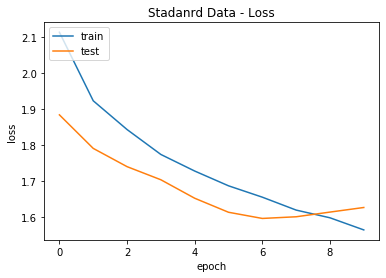

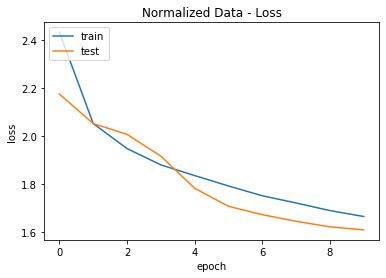

In [18]:
# Standard history for loss
plt.plot(best_orig_history.history['loss'])
plt.plot(best_orig_history.history['val_loss'])
plt.title('Stadanrd Data - Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Normalized history for loss
plt.plot(best_norm_history.history['loss'])
plt.plot(best_norm_history.history['val_loss'])
plt.title('Normalized Data - Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


### Train/Test accuracy comparison

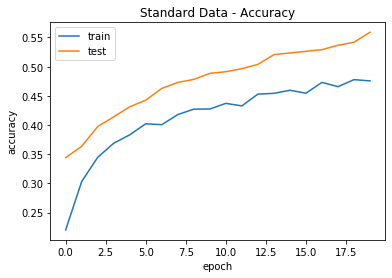

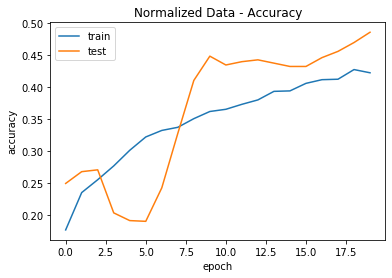

In [14]:
# Standard history for accuracy
plt.plot(best_orig_history.history['acc'])
plt.plot(best_orig_history.history['val_acc'])
plt.title('Standard Data - Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Standard history for accuracy
plt.plot(best_norm_history.history['acc'])
plt.plot(best_norm_history.history['val_acc'])
plt.title('Normalized Data - Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Conclusions

After 10 rounds of training with both datasets the results are:

* Normalized: 4 wins
* Standard: 6 wins

The overall train/loss difference among all rounds is very similar, but watching the means we can tell that the models trained with normalized average amplitude data got a slight smaller value. Even though, the difference is very small. Also, the Train/Loss gap is more stable with the standard data, what should be better.

Even though, in larger trainings (70+ epochs) I got more overfitted models using the normalized average amplitude data.

In one of the many materials I have been following I found more clues that point to the use of NON-normalized audio for classification tasks like the one here:

*As for normalization after db-scaling, that seems hit or miss depending on your data. From the paper above, the authors found nearly no difference using various normalization techniques for their data.*

Source: https://stackoverflow.com/questions/55513652/which-spectrogram-best-represents-features-of-an-audio-file-for-cnn-based-model/56727927#56727927

Related paper: [A Comparison of Audio Signal Preprocessing Methods for Deep Neural Networks on Music Tagging](https://arxiv.org/abs/1709.01922)

I may continue experimenting with other type of normalization over the data that do not involve modifying the original audio dynamics. Or, in contrast, experiment augmenting data by random amplitude average alteration.